# Topik: Computer Vision (Klasifikasi)

**Dataset:** 6800 gambar dari **Cats vs Dogs**, terbagi dalam 2 kelas.
* 6000 Train data
* 800 Test data
---

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
(raw_train, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:6000]', 'train[6000:6800]'],
    with_info=True,
    as_supervised=True,
)

def preprocess_image(image, label):
    """Preprocess images: resize and normalize"""
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


BATCH_SIZE = 16
BUFFER_SIZE = 1000

train_dataset = (raw_train
                .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(BUFFER_SIZE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

test_dataset = (raw_test
               .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))

print("Training batches:", len(train_dataset))
print("Testing batches:", len(test_dataset))


Training batches: 375
Testing batches: 50


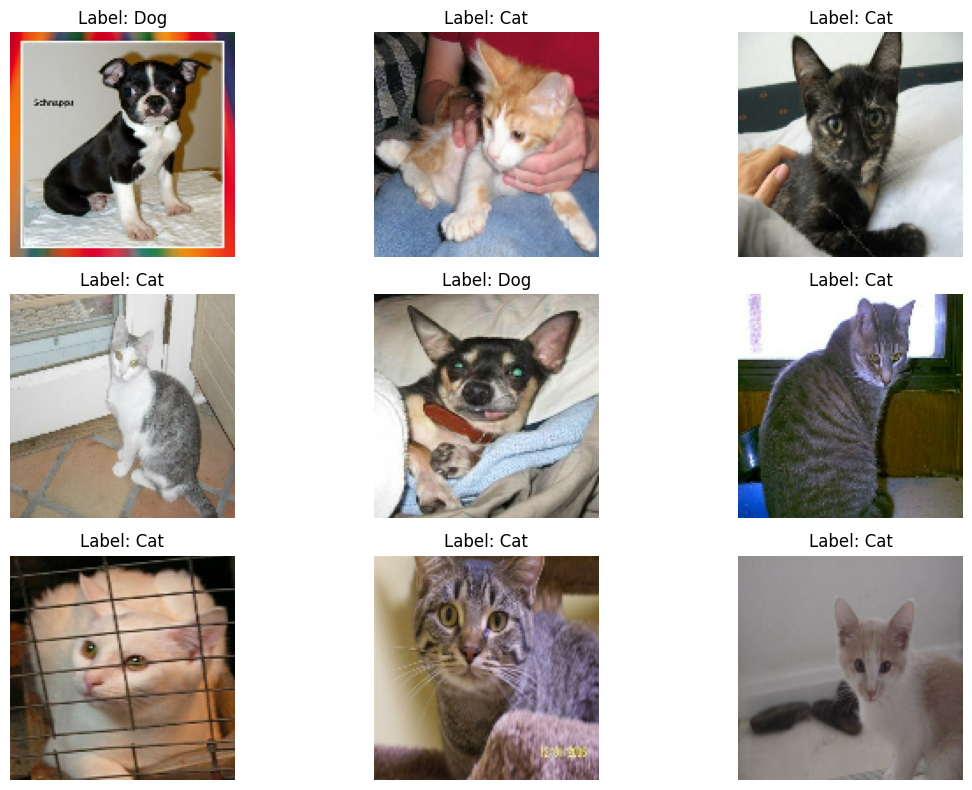

In [ ]:
def plot_sample_images(dataset, num_images=9):
    plt.figure(figsize=(12, 8))
    class_names = ['Cat', 'Dog']

    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image[0])
        plt.title(f'Label: {class_names[int(label[0])]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(train_dataset)

## Model Baseline

In [ ]:
def create_baseline_cnn():
    inputs = layers.Input(shape=(128, 128, 3))

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

baseline_model = create_baseline_cnn()
baseline_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,048,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,141,889 (4.36 MB)

 Trainable params: 1,141,889 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
baseline_history = baseline_model.fit(
    train_dataset,
    epochs=15,
    validation_data=test_dataset,
    verbose=1
)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5069 - loss: 0.6955 - val_accuracy: 0.6250 - val_loss: 0.6729
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5706 - loss: 0.6722 - val_accuracy: 0.6712 - val_loss: 0.6154
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6471 - loss: 0.6316 - val_accuracy: 0.6925 - val_loss: 0.5780
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.6806 - loss: 0.5947 - val_accuracy: 0.7125 - val_loss: 0.5626
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6891 - loss: 0.5851 - val_accuracy: 0.7200 - val_loss: 0.5384
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7132 - loss: 0.5656 - val_accuracy: 0.7462 - val_loss: 0.5347
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7206 - loss: 0.5581 - val_accuracy: 0.7300 - val_loss: 0.5398
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7278 - loss: 0.5503 - val

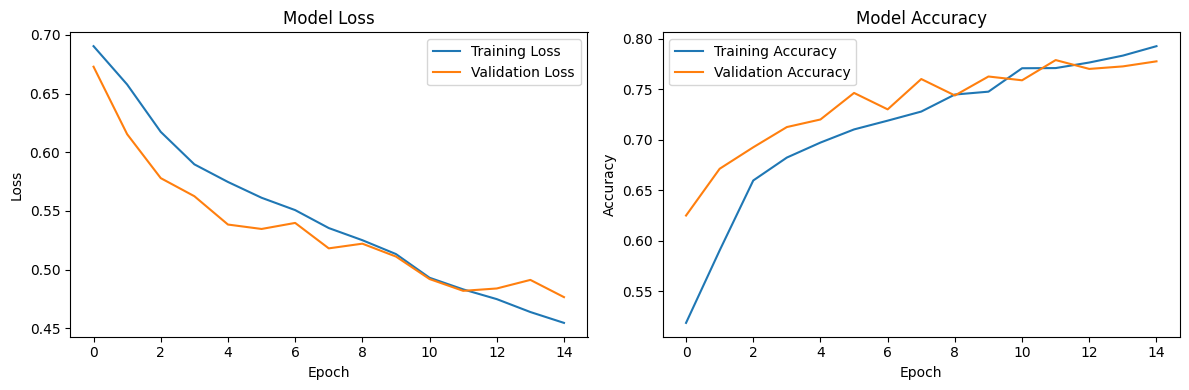


Baseline Model Final Results on Test Set:
Test Accuracy: 0.7775
Test Loss: 0.4766


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(baseline_history.history['loss'], label='Training Loss')
plt.plot(baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_history.history['accuracy'], label='Training Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate baseline model
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(test_dataset, verbose=0)
print(f"\nBaseline Model Final Results on Test Set:")
print(f"Test Accuracy: {baseline_test_acc:.4f}")
print(f"Test Loss: {baseline_test_loss:.4f}")

## Implementasi Solusi

In [ ]:
# [TULIS KODE SOLUSI ANDA DI SINI]
# Contoh: Membangun model baru, menerapkan augmentasi, dll.

# model_solusi = ...


In [ ]:
# [JIKA PERLU, TAMBAHKAN SEL KODE LAGI DI SINI]

# Melatih model solusi Anda
# history_solusi = model_solusi.fit(...)

## Perbandingan dan Analisis Akhir

In [ ]:
# [TULIS KODE UNTUK EVALUASI DAN VISUALISASI MODEL SOLUSI ANDA DI SINI]

# Contoh:
# loss_solusi, accuracy_solusi = model_solusi.evaluate(x_test, y_test)
# print(f"Akurasi Model Solusi: {accuracy_solusi*100:.2f}%")

# Plot learning curves
# plt.plot(...)

## Analisis Akhir

**Isi bagian di bawah ini sesuai dengan hasil yang Anda dapatkan.**

**Pendekatan Solusi:** [Jelaskan secara singkat pendekatan yang Anda pilih]

**Perbandingan Performa:**
- Akurasi Model Baseline: [Isi dengan akurasi baseline pada data test, misal: 77.7%]
- Akurasi Model Solusi: [Isi dengan akurasi model Anda pada data test]

**Analisis Singkat:**
[Jelaskan mengapa solusi Anda berhasil meningkatkan akurasi. Apa yang membuat pendekatan Anda lebih baik daripada model baseline? Jika ada tantangan, sebutkan juga di sini.]